### This is a notebook for the supplement section on PCA explained variance
Illustrates why we decided to use nonlinear dimensionality reduction methods and manifold learning.

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import configurations
import os
from pathlib import Path
from src.dimensionality_reduction import compute_covariance, explained_variance
from src.core_pipeline import GMM_clustering_R
import sklearn.decomposition
#Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import datetime
import scipy
from src.config import configurations
from src.dimensionality_reduction import compute_covariance, visualize_manifold_method, choose_dimension
from src.utils import define_paths, load_data, convert_to_python_dict, save_obj, load_obj, find_closest_time_series
from src.utils import plot_time_series
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
from sklearn.manifold import Isomap, SpectralEmbedding, LocallyLinearEmbedding, trustworthiness
from sklearn.manifold import trustworthiness
from copy import copy 
from kneed import DataGenerator, KneeLocator
import pickle
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import scipy
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [3]:
project_dir = configurations['PROJECT_DIR']
#Check that the directory with the supplement figures exists
Path(os.path.join(project_dir, 'reports', 'figures', 'supplement')).mkdir(parents=True, exist_ok=True)

In [4]:
#Load the covid behavior dataset:
state_names = ['WASHINGTON', 'GEORGIA', 'TEXAS', 'CALIFORNIA']
stayathome_states = [pd.read_csv(configurations[i+'_RAW_DATA_PATH'], index_col = 'Unnamed: 0').dropna() for i in state_names]
stayathome_states = [state[state.columns[:117]] for state in stayathome_states] #Take the first 117 days

In [5]:
#Look at the fraction of explained variance
#Suggest that maybe a linear dimensionality reduction is not perfect in this case
fs = 10
enlarge =  5
sns.set(style="whitegrid")
plt.figure(figsize = (enlarge*4,enlarge*3))
for i, state in enumerate(stayathome_states):
    plt.plot(explained_variance(state), '-o', label = state_names[i].title())
# plt.title('Fraction of explained variance vs. number of PCA components', fontsize = enlarge*fs)
plt.ylabel('Fraction of Explained Variance', fontsize = enlarge*fs)
plt.xlabel('Number of PCA components', fontsize = enlarge*fs)
plt.tick_params(axis='both', which='major', labelsize=6*5)
plt.legend(fontsize = enlarge*fs)
plt.savefig(os.path.join(configurations['FIGURE_PATH'], 'supplement', 'PCA_explained_variance.pdf'))

### Let's look at 3D projection and clustering done in 11 dim space

In [6]:
#Take Washington
X = stayathome_states[0].values

In [7]:
#Compute Covariance Matrix
mu, Sigma = compute_covariance(X)
l, V = np.linalg.eig(Sigma)

used_components = 8
X_pca = (X - mu).dot(V[:,:used_components])
X_pca.shape
X_pca_df = pd.DataFrame(X_pca, columns = ['Mode {}'.format(i) for i in range(used_components)])#, index = index_X)
X_pca_df.to_csv(os.path.join(configurations['DATA_PATH'], 'interim', 'PCA_behavior.csv'))

fitting ...
  |======================================================================| 100%
Elbow point: 3 components with BIC 25363.316977575814
fitting ...
  |======================================================================| 100%
---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VEE (ellipsoidal, equal shape and orientation) model with 11 components: 

 log-likelihood    n  df      BIC      ICL
       13722.97 4752 144 26226.79 21941.34

Clustering table:
   1    2    3    4    5    6    7    8    9   10   11 
 117  220  135  883  175  201  291 1144  382  776  428 

Uncertainty quantiles: [1.28379822e-07 1.89785536e-01 3.41615768e-01 4.85534702e-01
 7.73945024e-01]
['VEE']


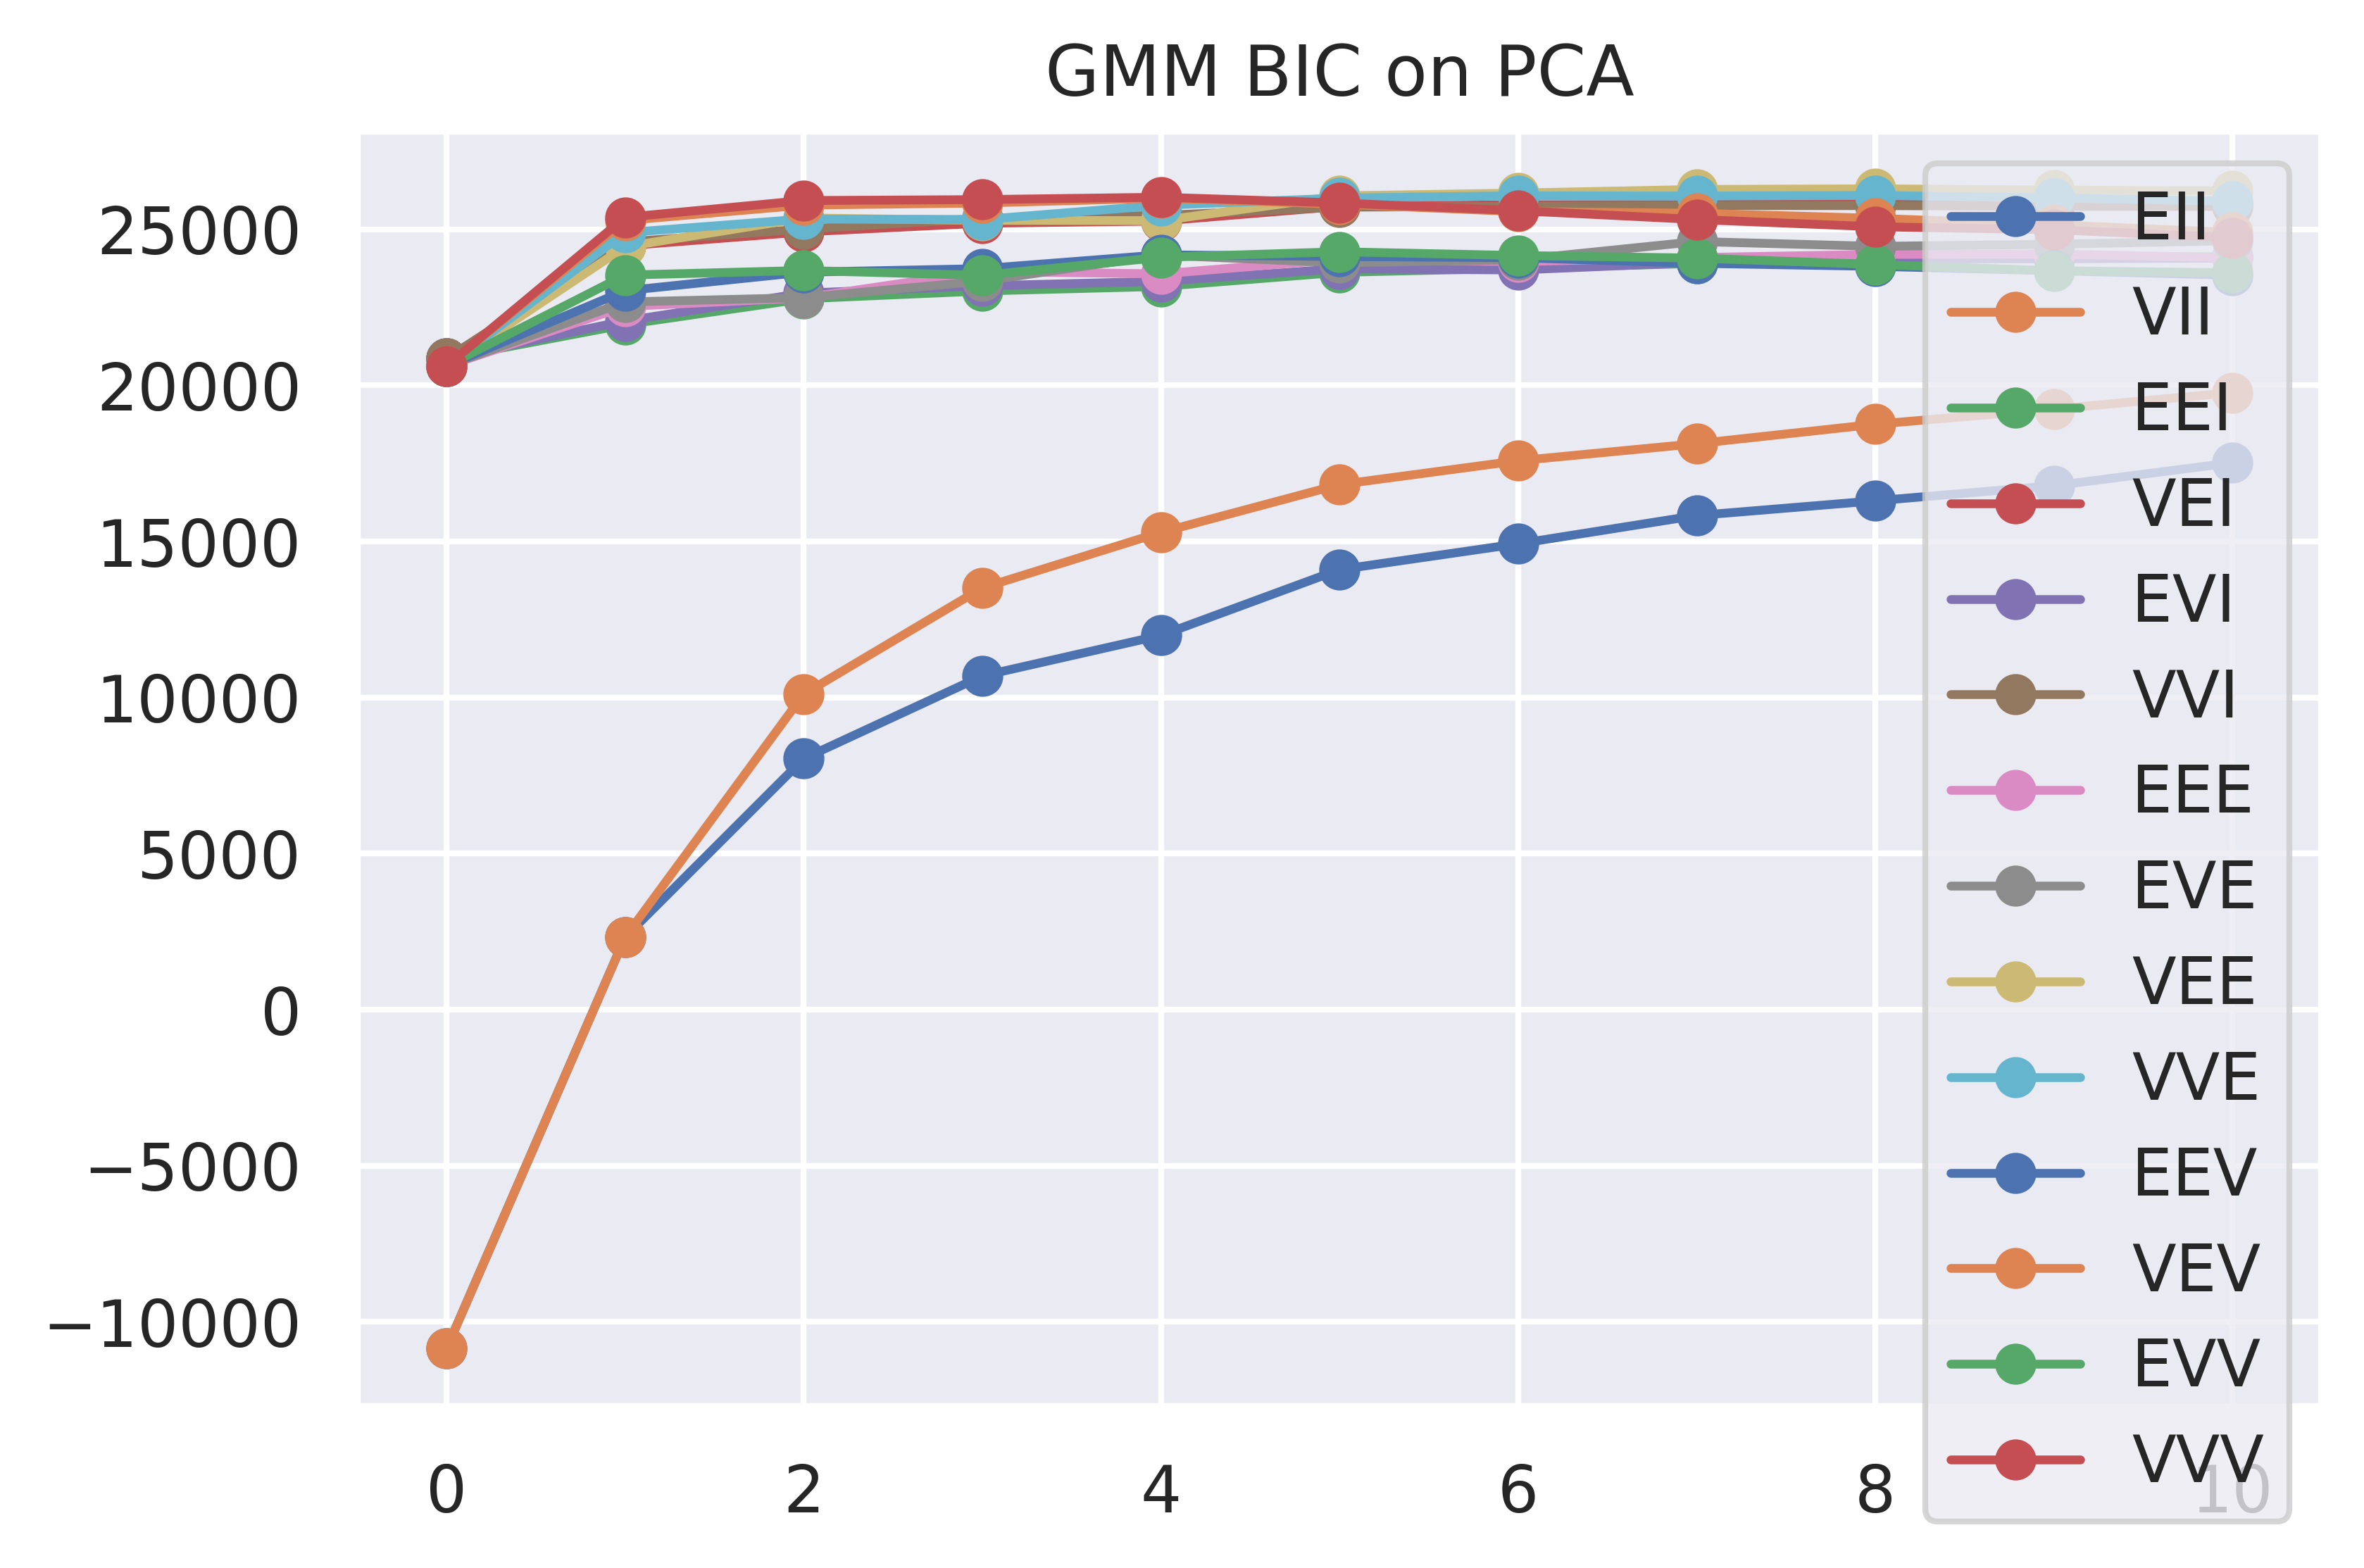

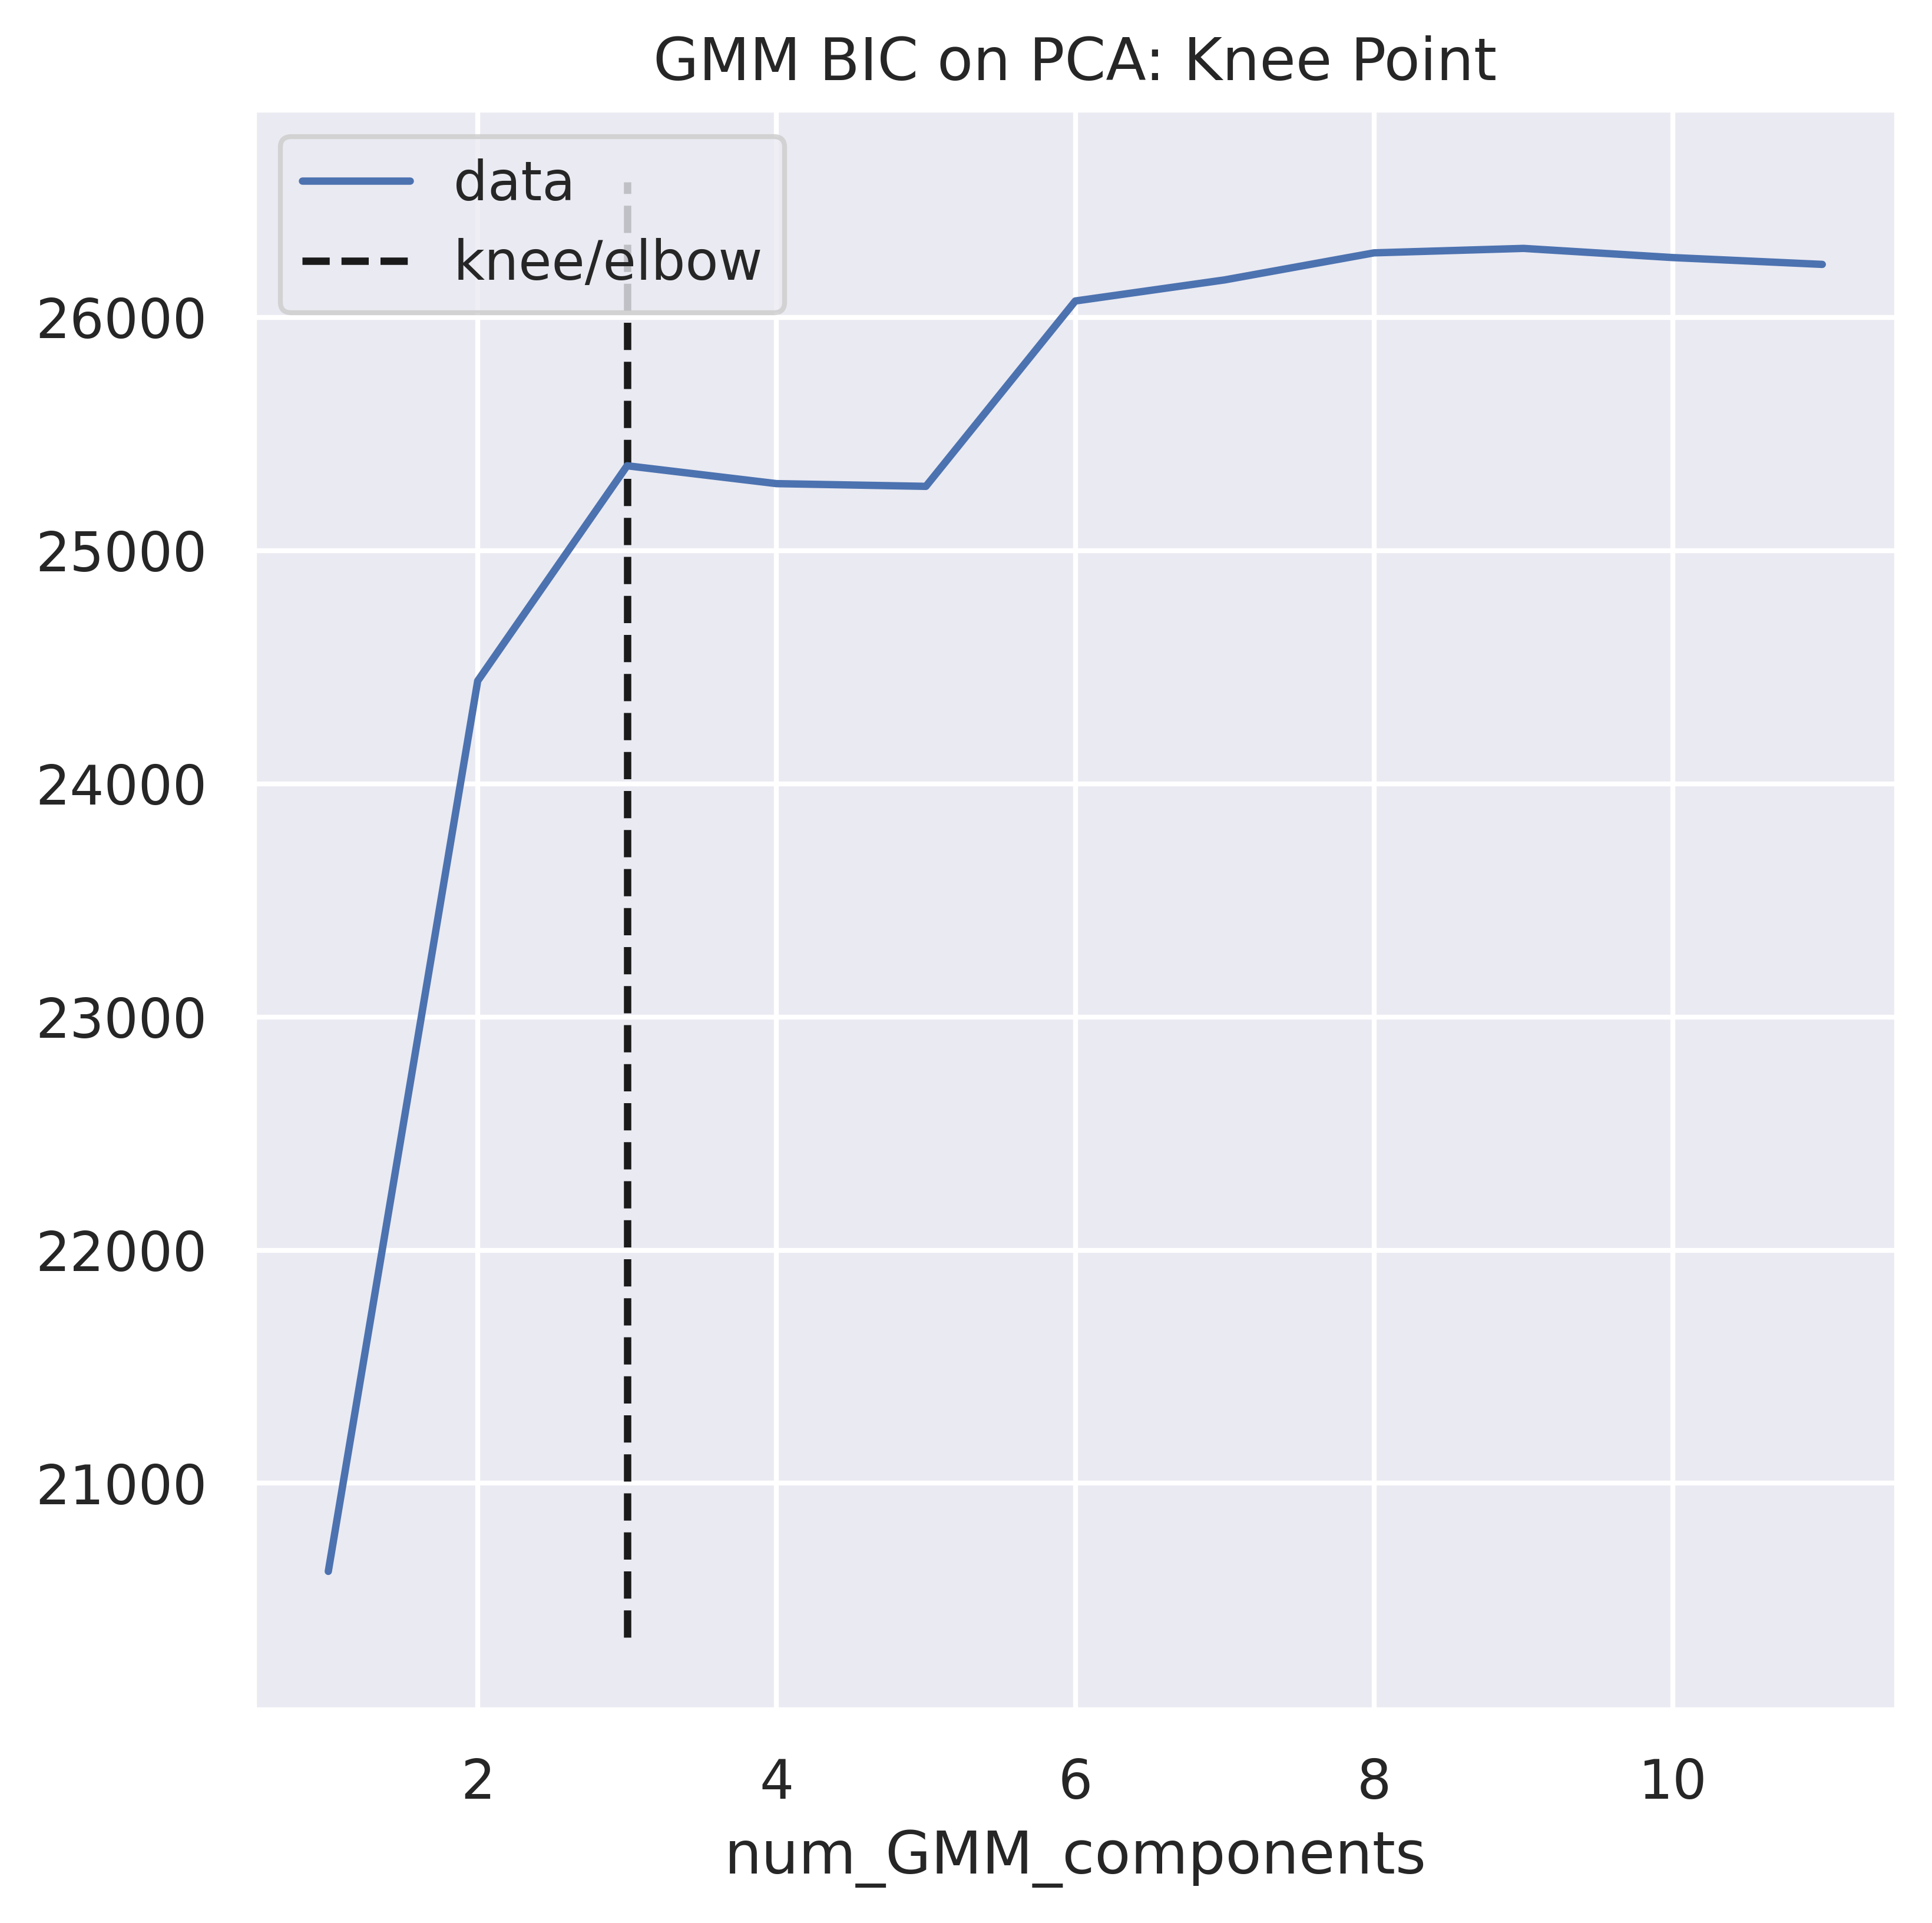

In [8]:
clusters, means, z, uncertainty = GMM_clustering_R(X_pca_df, sklearn.decomposition.PCA, 11)

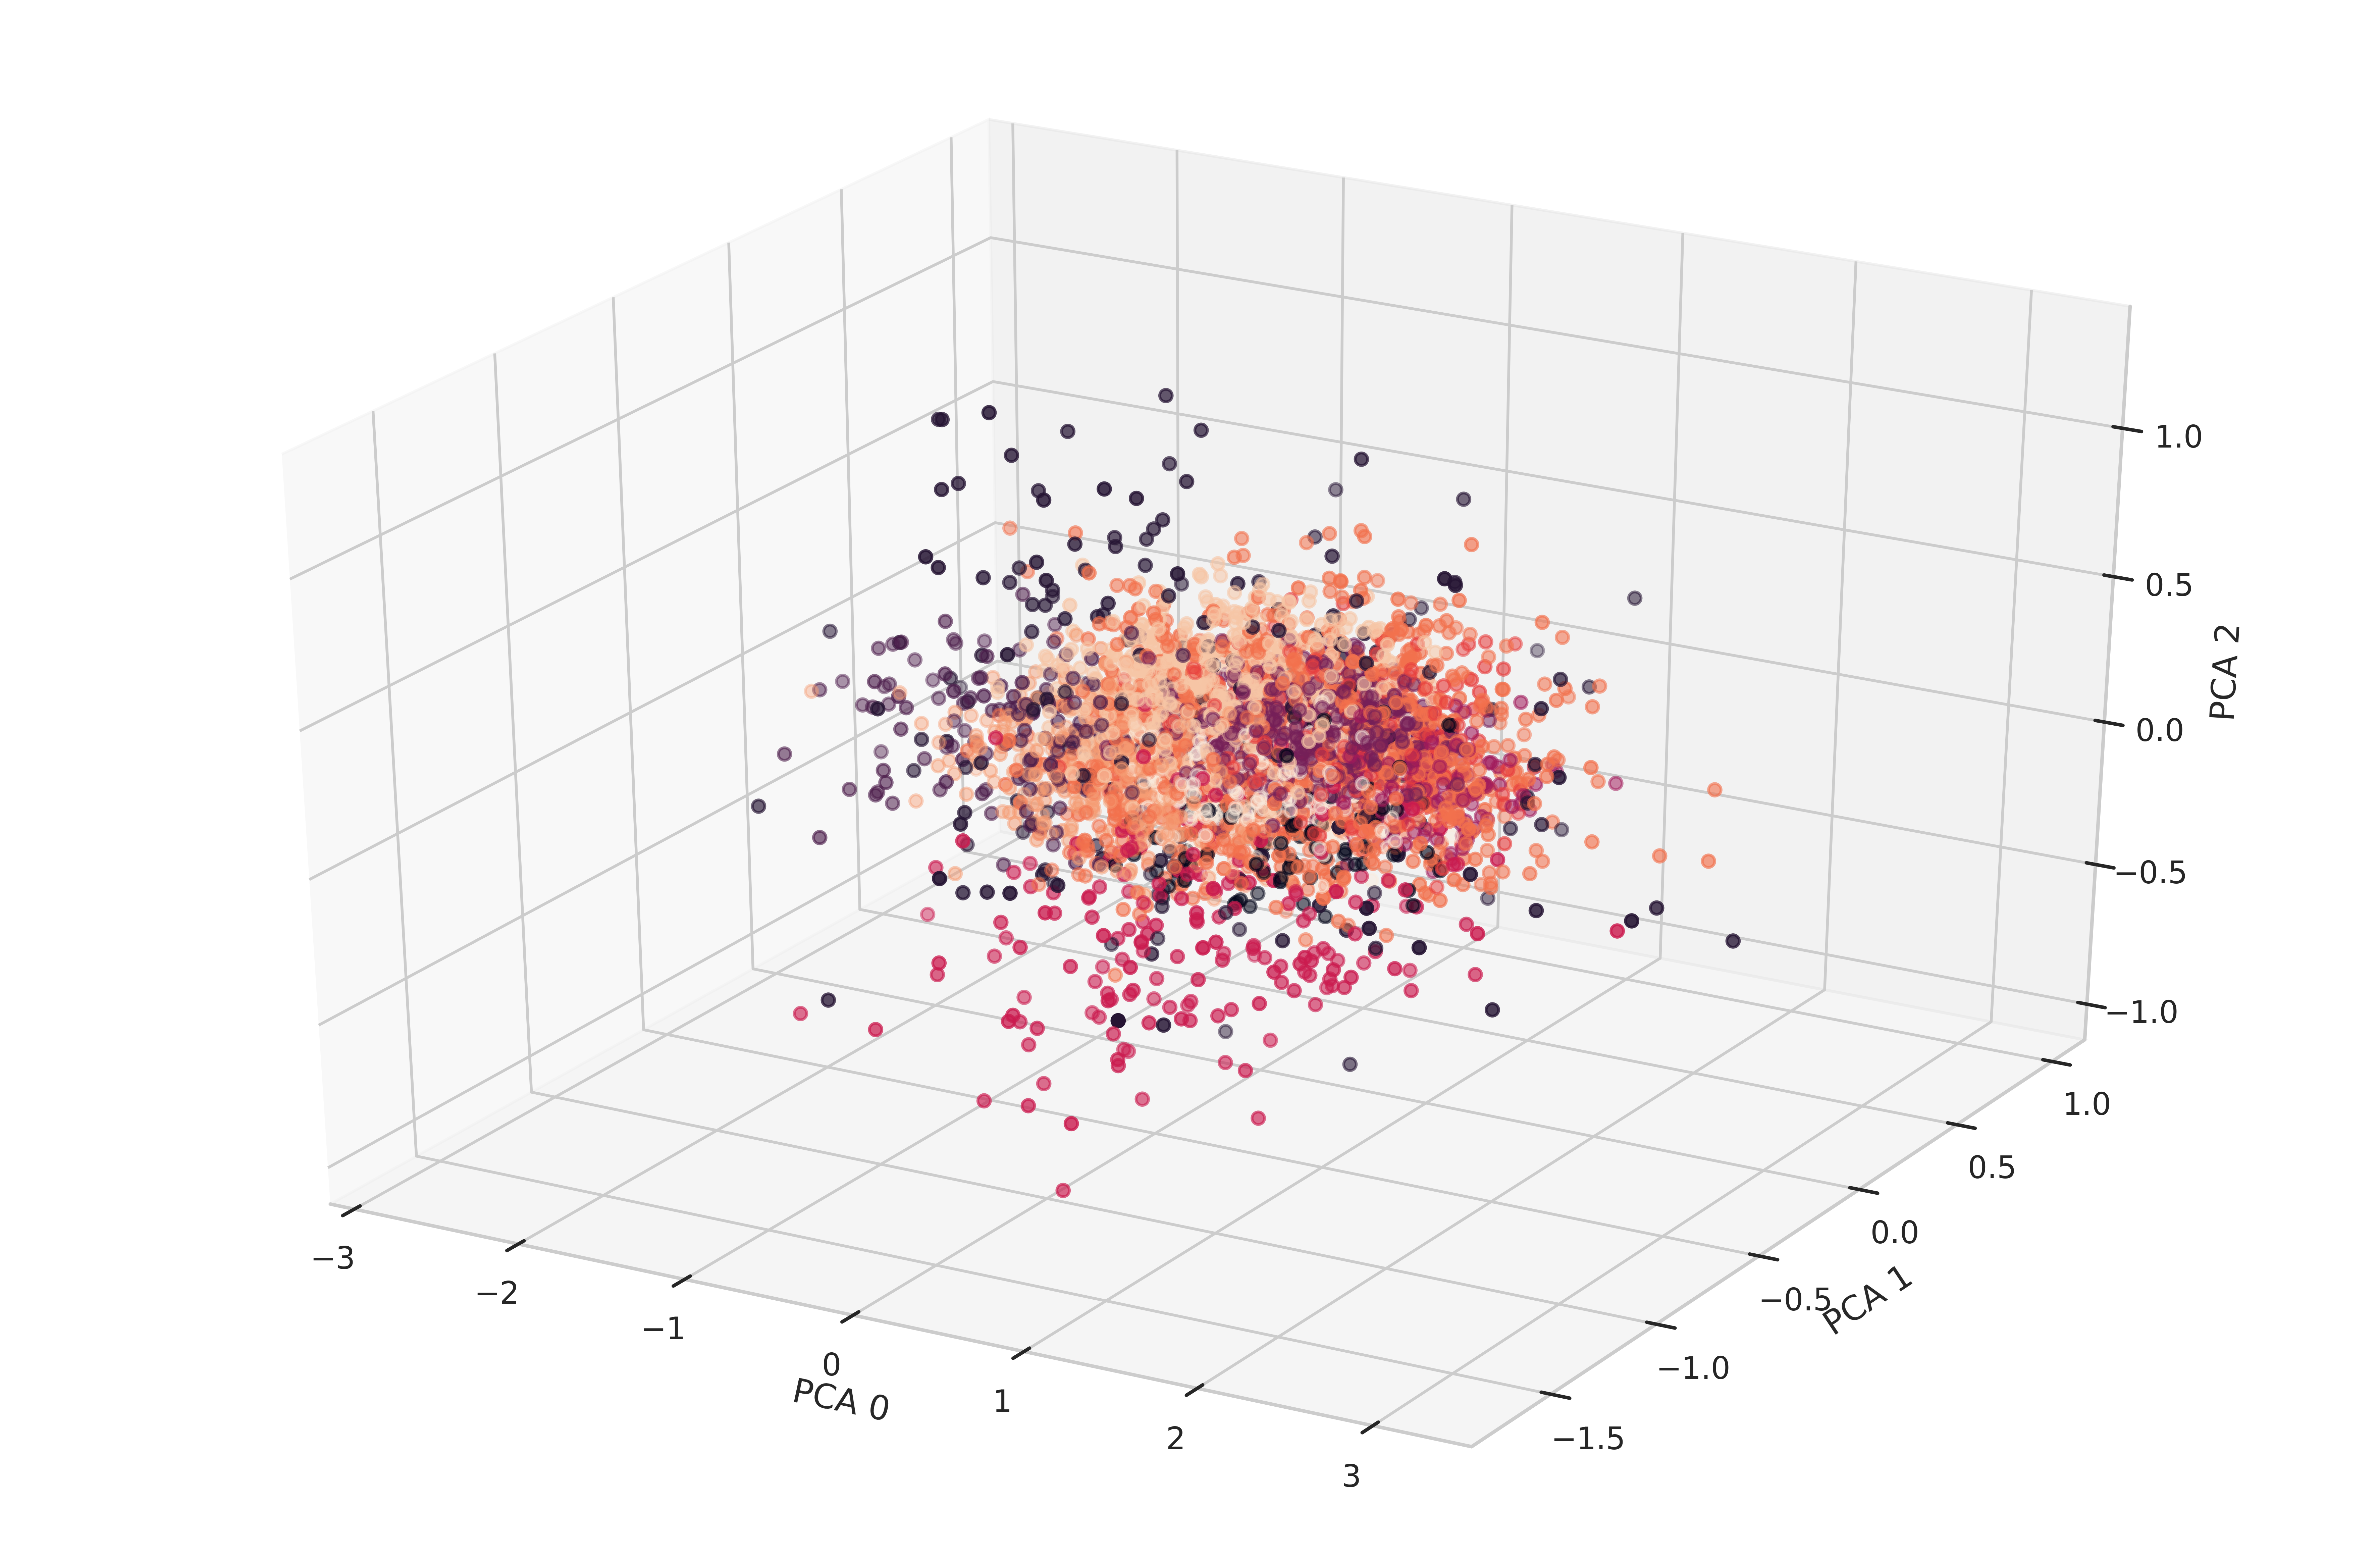

In [10]:
from mpl_toolkits.mplot3d import Axes3D  


sns.set(style="whitegrid")
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca_df['Mode 0'], X_pca_df['Mode 1'], X_pca_df['Mode 2'], c=clusters)

ax.set_xlabel('PCA 0')
ax.set_ylabel('PCA 1')
ax.set_zlabel('PCA 2')
# ax.set_title('Washington PCA 3D projection')

fig.savefig(os.path.join(configurations['FIGURE_PATH'], 'supplement', '3D_PCA.pdf'),
           bbox_inches = 'tight')